In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

import calendar
from datetime import datetime as dt
import json

Let's read the data from JSON and make it a pandas DataFrame.

In [3]:
f = open("messages.json")
messages = pd.read_json(f)
f.close()

In [4]:
messages.head(16)

,channel_name,text,ts,user_name
0,f8-ad-creative-log,:wave:,1.434642e+09,samstefan
1,f8-ad-creative-log,<@U02FKV9J0>: <@U04Q5JSM4> FYI - worth keeping...,1.434706e+09,joemccabe
2,f8-ad-creative-log,"ok, thanks",1.434707e+09,maxweston
3,f8-ad-creative-log,:eyes:,1.434707e+09,mattgdavies
4,f8-ad-creative-log,:nose: \n:lips:,1.434707e+09,mattgdavies
5,fanbookz-testing,This jenkins clouds configuration interface is...,1.424947e+09,mattsenior
6,fanbookz-testing,I could have sworn that it did that when I was...,1.424947e+09,gzankevich
7,fanbookz-testing,dat tick,1.424952e+09,gzankevich
8,fanbookz-testing,hnnnng,1.424952e+09,gzankevich
9,fanbookz-testing,uhhh,1.424952e+09,augier


## Change Slack user IDs to usernames
### Load users and build a dictionary for O(1) lookups

In [5]:
user_names = {}
with open("users.json") as f:
    users = json.load(f)
    user_names = {user["id"]: user["name"] for user in users}
    user_names["USLACKBOT"] = "slackbot"

### Find occurences of Slack user IDs and replace them with usernames

In [6]:
import re
re_user = re.compile("<@(U[A-Z0-9]+)>")

def resolve_user(text):
    return re.sub(re_user, lambda m: "@"+user_names[m.group(1)], text)

messages["text"] = messages["text"].map(resolve_user)

## Find the most popular emojis
### Load the lists of default emojis and custom emojis

In [7]:
emoji_list = []
with open("emoji.json") as f:
    emoji_list = json.load(f)
with open("emoji_custom.json") as f:
    emoji_list += json.load(f)["emoji"].keys()

### Get top 10 emojis and make a bar plot

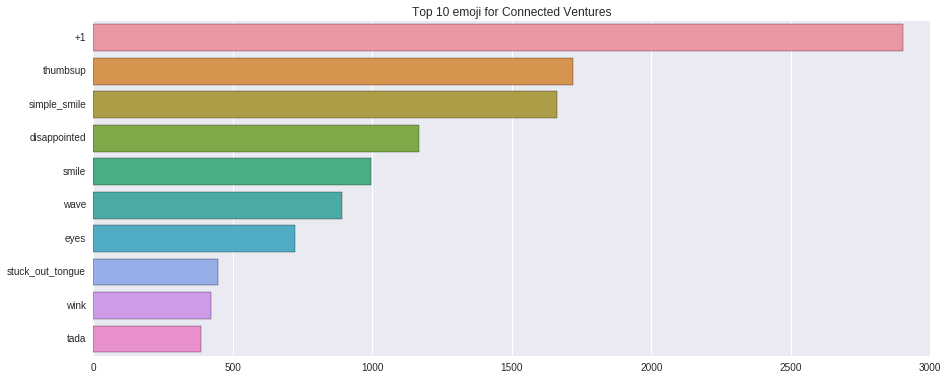

In [134]:
re_emoji = re.compile(r":([^:.]+):")

def get_emoji(text):
    matches = re_emoji.finditer(text)
    return [match.group(1) for match in matches if match.group(1) in emoji_list]

emoji = [emoji for text in messages["text"] for emoji in get_emoji(text)]

from collections import Counter

emoji_counter = Counter(emoji)
emoji_top = emoji_counter.most_common(10)
emoji_top20 = [name for name, _ in emoji_counter.most_common(15)]

plt.figure(figsize=(15, 6))
plt.title("Top 10 emoji for Connected Ventures")
_ = sb.barplot(x=[c for _, c in emoji_top], 
           y=[e for e,_ in emoji_top])

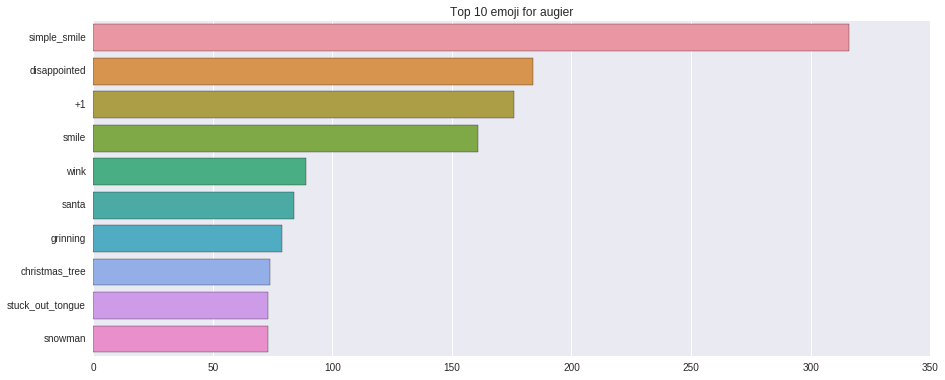

In [135]:
chris_messages = messages[messages["user_name"]=="augier"]
chris_emoji = [emoji for text in chris_messages["text"] for emoji in get_emoji(text)]
emoji_top_augier = Counter(chris_emoji).most_common(10)

plt.figure(figsize=(15, 6))
plt.title("Top 10 emoji for augier")
_ = sb.barplot(x=[c for _, c in emoji_top_augier], 
           y=[e for e,_ in emoji_top_augier])

def user_emoji(user):
    msgs = messages[messages["user_name"]==user]
    return [text_emoji for text in msgs["text"] for text_emoji in get_emoji(text) if text_emoji in emoji_top20]
    
user_emoji_lists = [(user, user_emoji(user)) for user in user_names.values()]

def user_emoji_ratios(user_emoji):
    c = Counter(user_emoji)
    ratios = {name: c[name]/len(user_emoji) for name in c}
    for em in emoji_list:
        if em not in ratios:
            yield 0
        else:
            yield ratios[em]

user_ratios = [(user, list(user_emoji_ratios(emoji_list))) for user, emoji_list in user_emoji_lists if len(emoji_list) > 100]

(17, 4)
(18, 18)


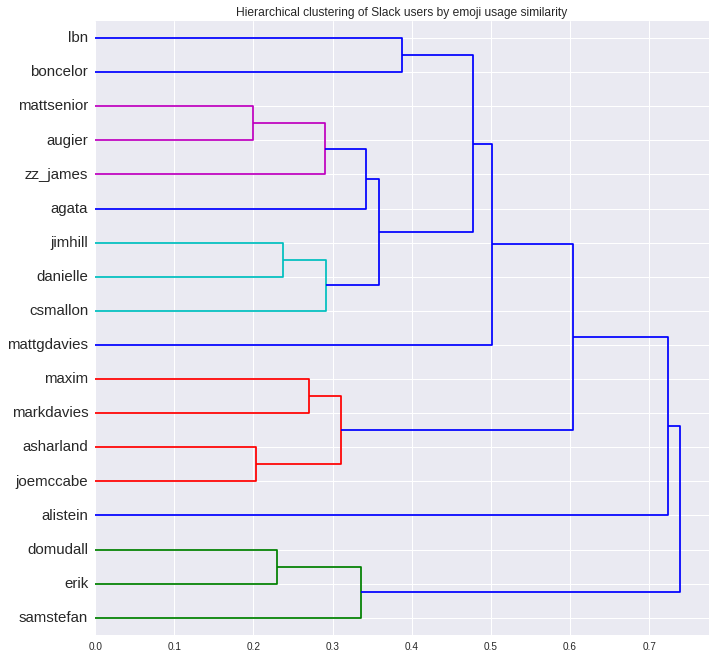

In [161]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

X = np.array([ratios for _, ratios in user_ratios])
Z = linkage(X, method="average")
print(Z.shape)
dist_mat = squareform(pdist(X))
print(dist_mat.shape)

with open("Z.json", "w") as f:
    json.dump(dist_mat.tolist(), f)


fig = plt.figure(figsize=(11,11))
_ = dendrogram(
    Z,
    color_threshold=0.34,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=15.,  # font size for the x axis labels
    labels=[user for user, _ in user_ratios],
    orientation="left"
)
plt.title("Hierarchical clustering of Slack users by emoji usage similarity")
fig.savefig('test2png.png', dpi=120)